<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/10_SKIMLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts eaiser.

we went through some fundamental natural lanuage processing concepts. The main ones being tokenzation (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially,[ we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT:](https://arxiv.org/pdf/1710.06071) a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

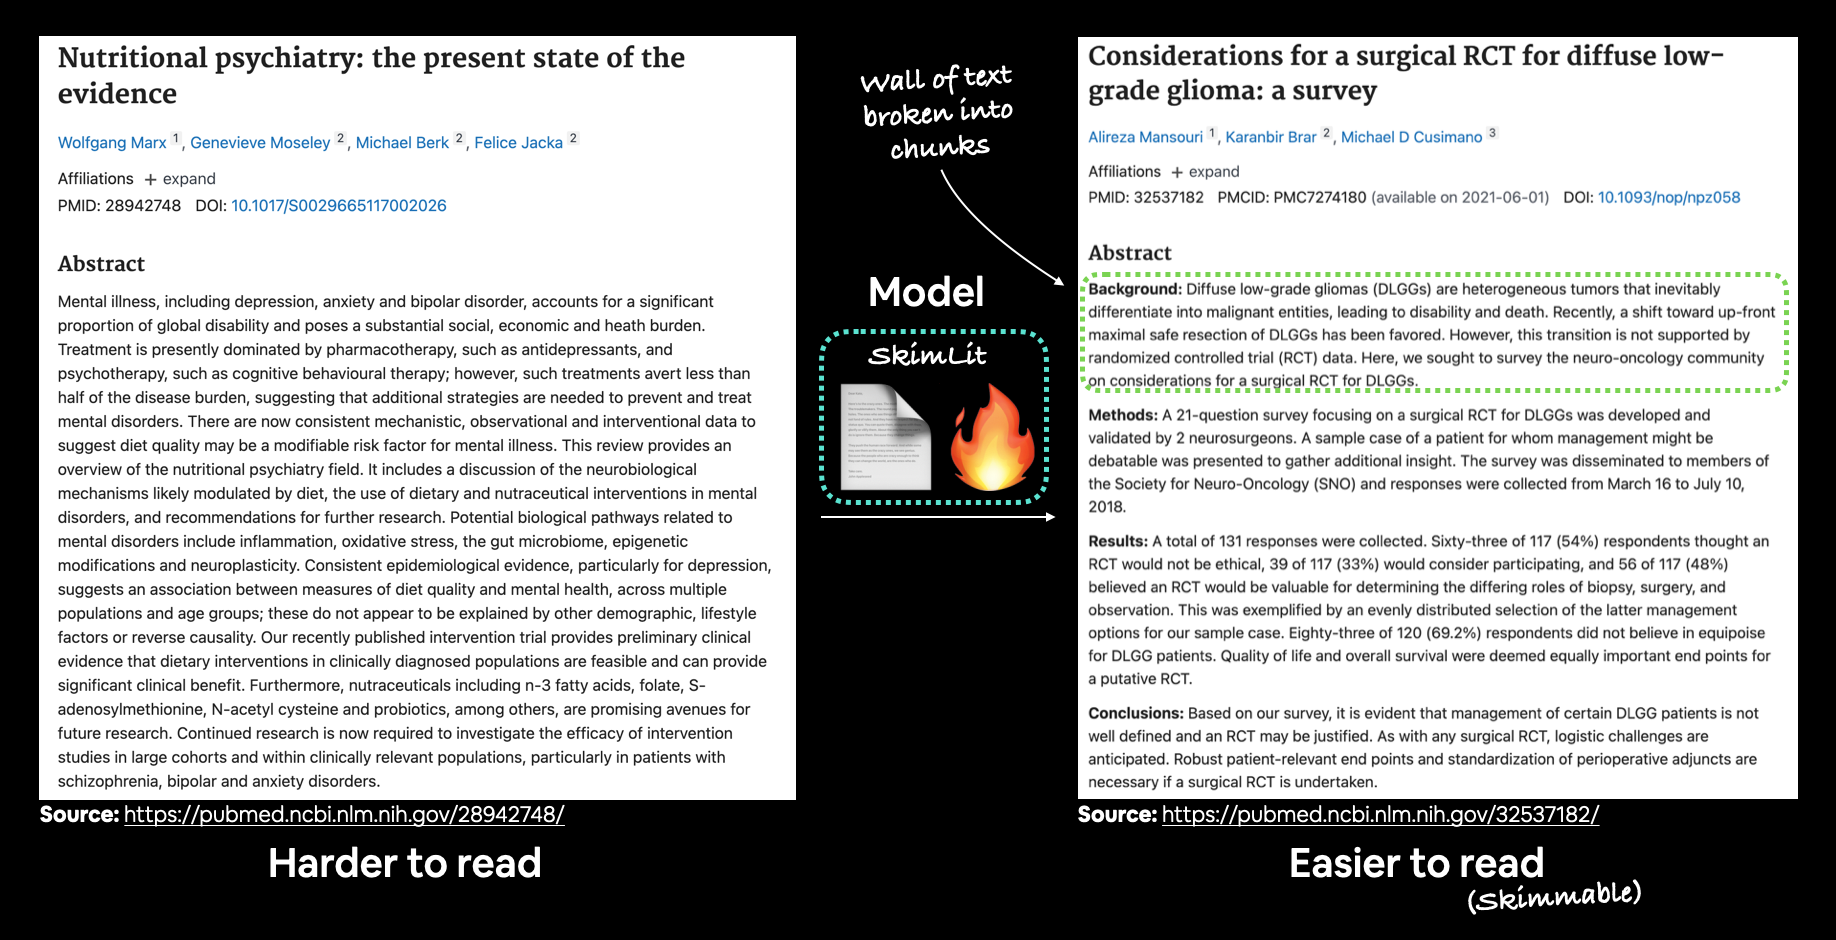

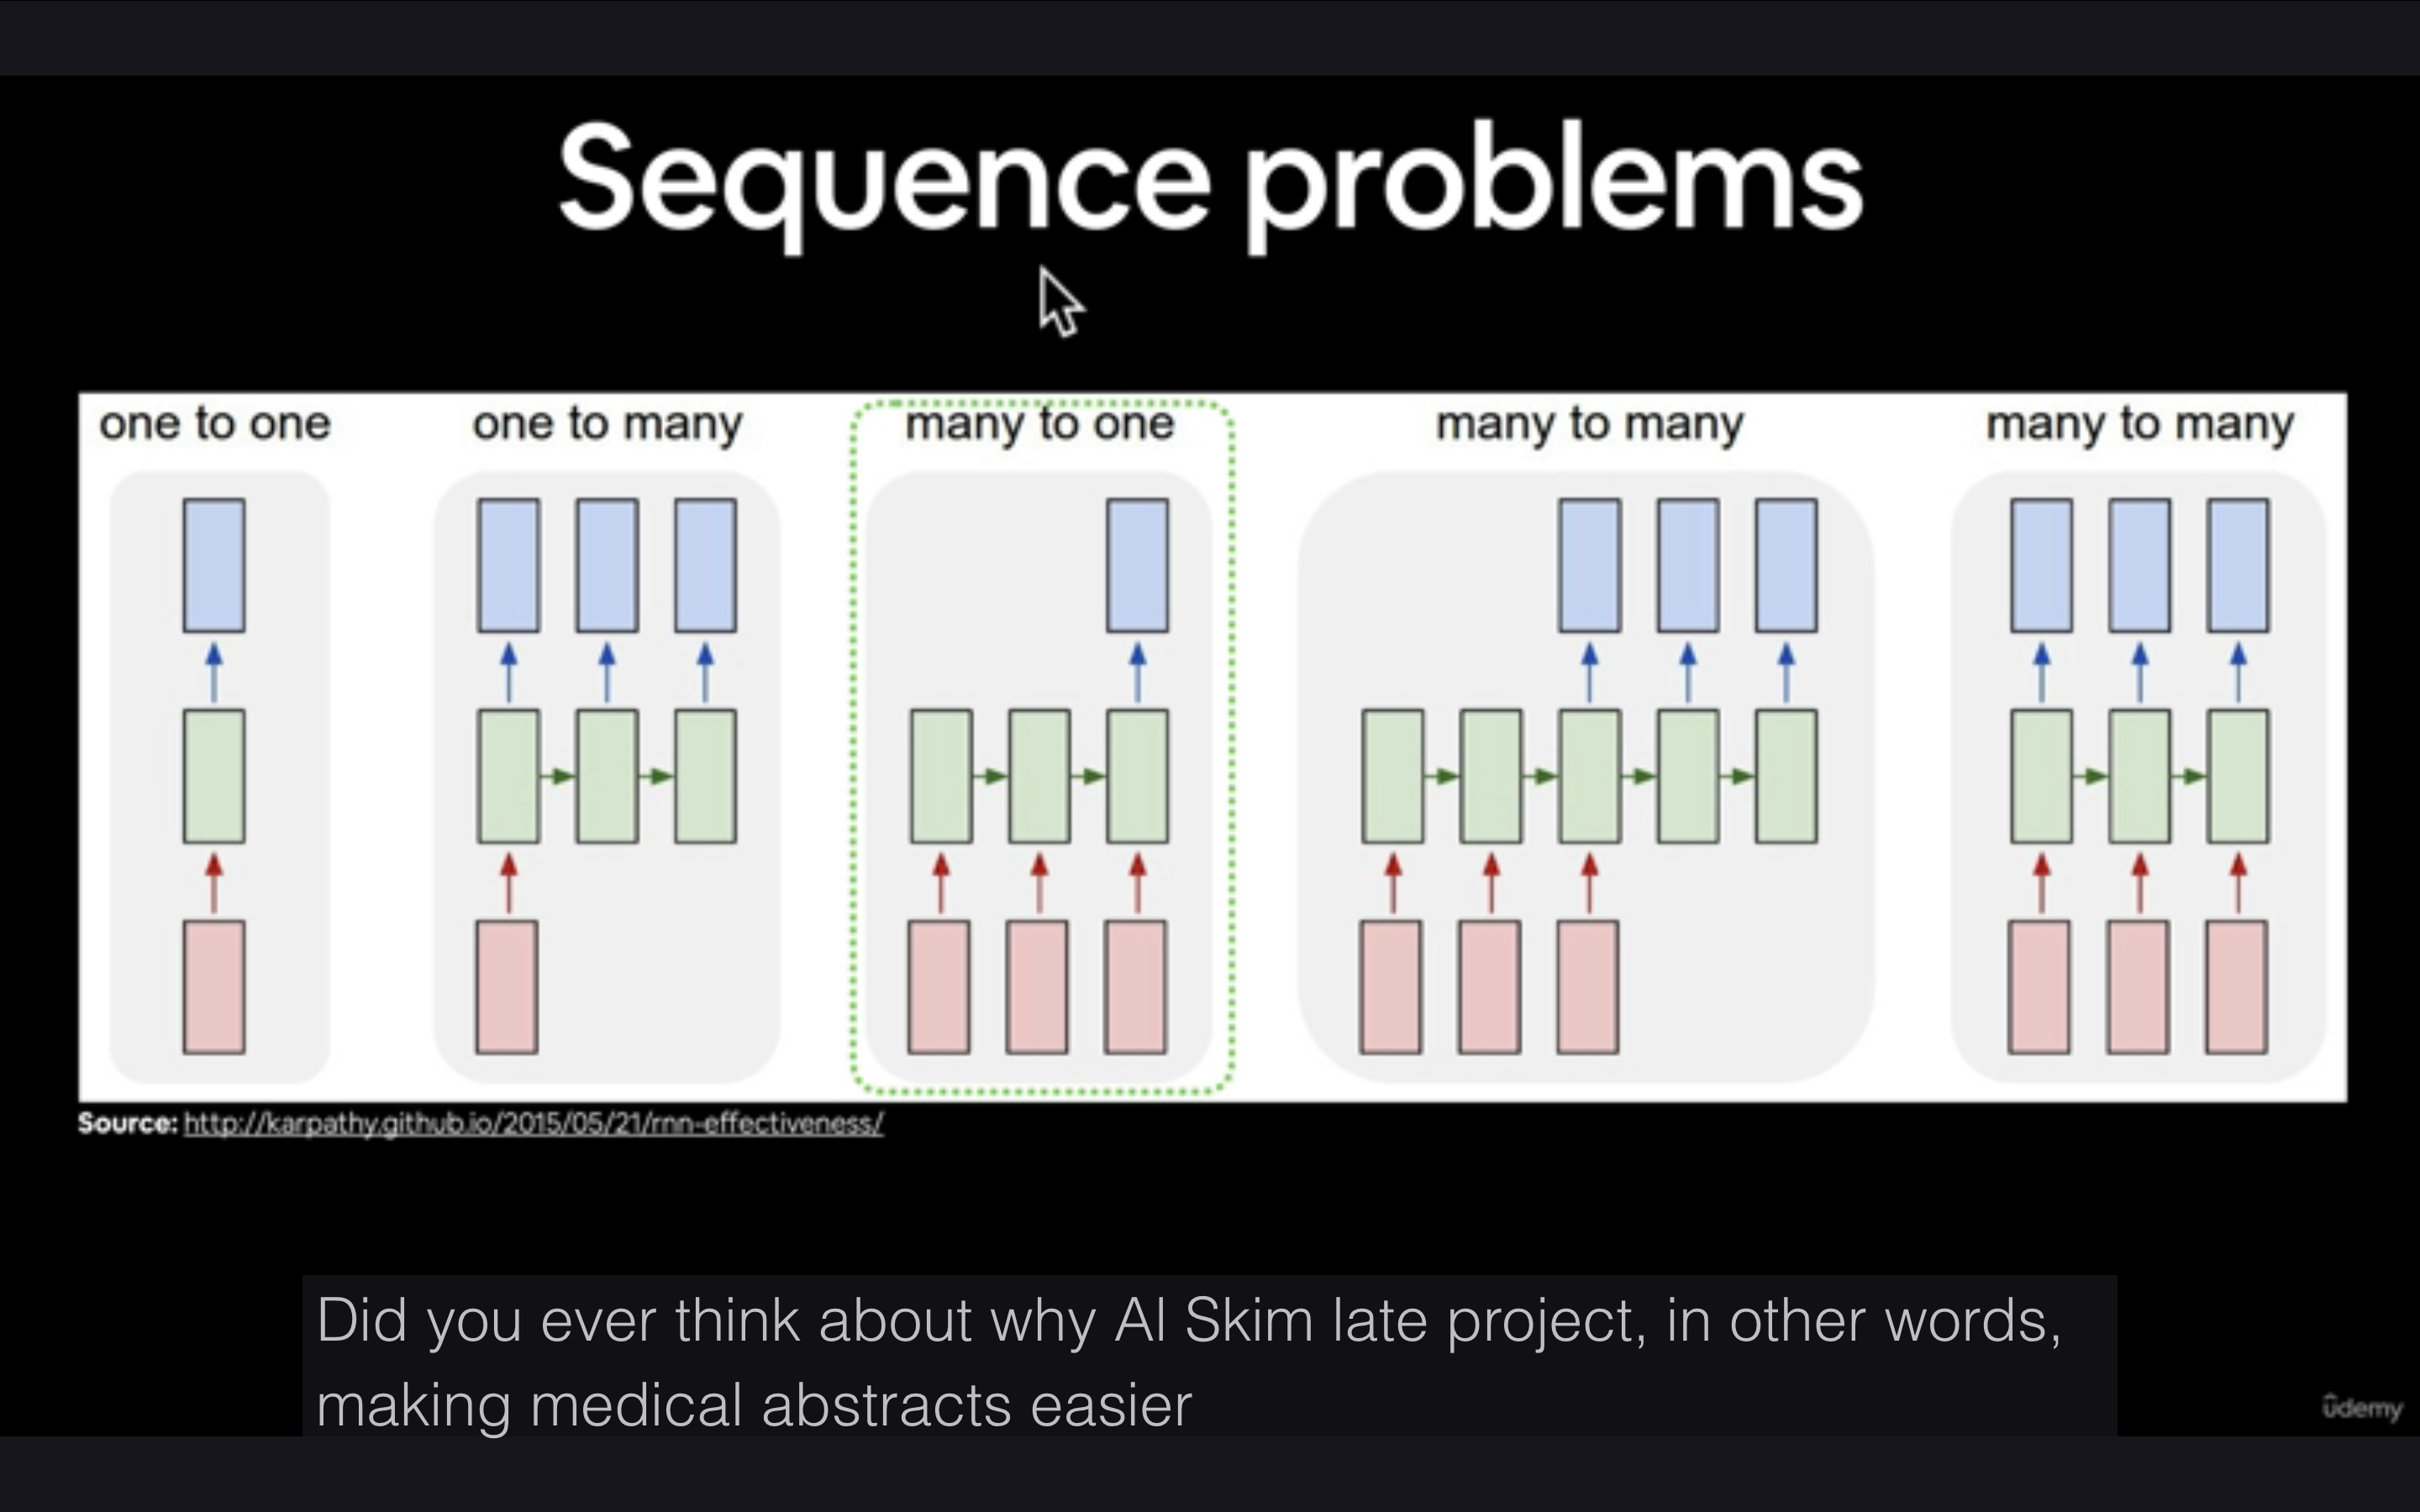

##Problem in a sentence
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literatur

##Solution in a sentence
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

1. Where our data is coming from: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

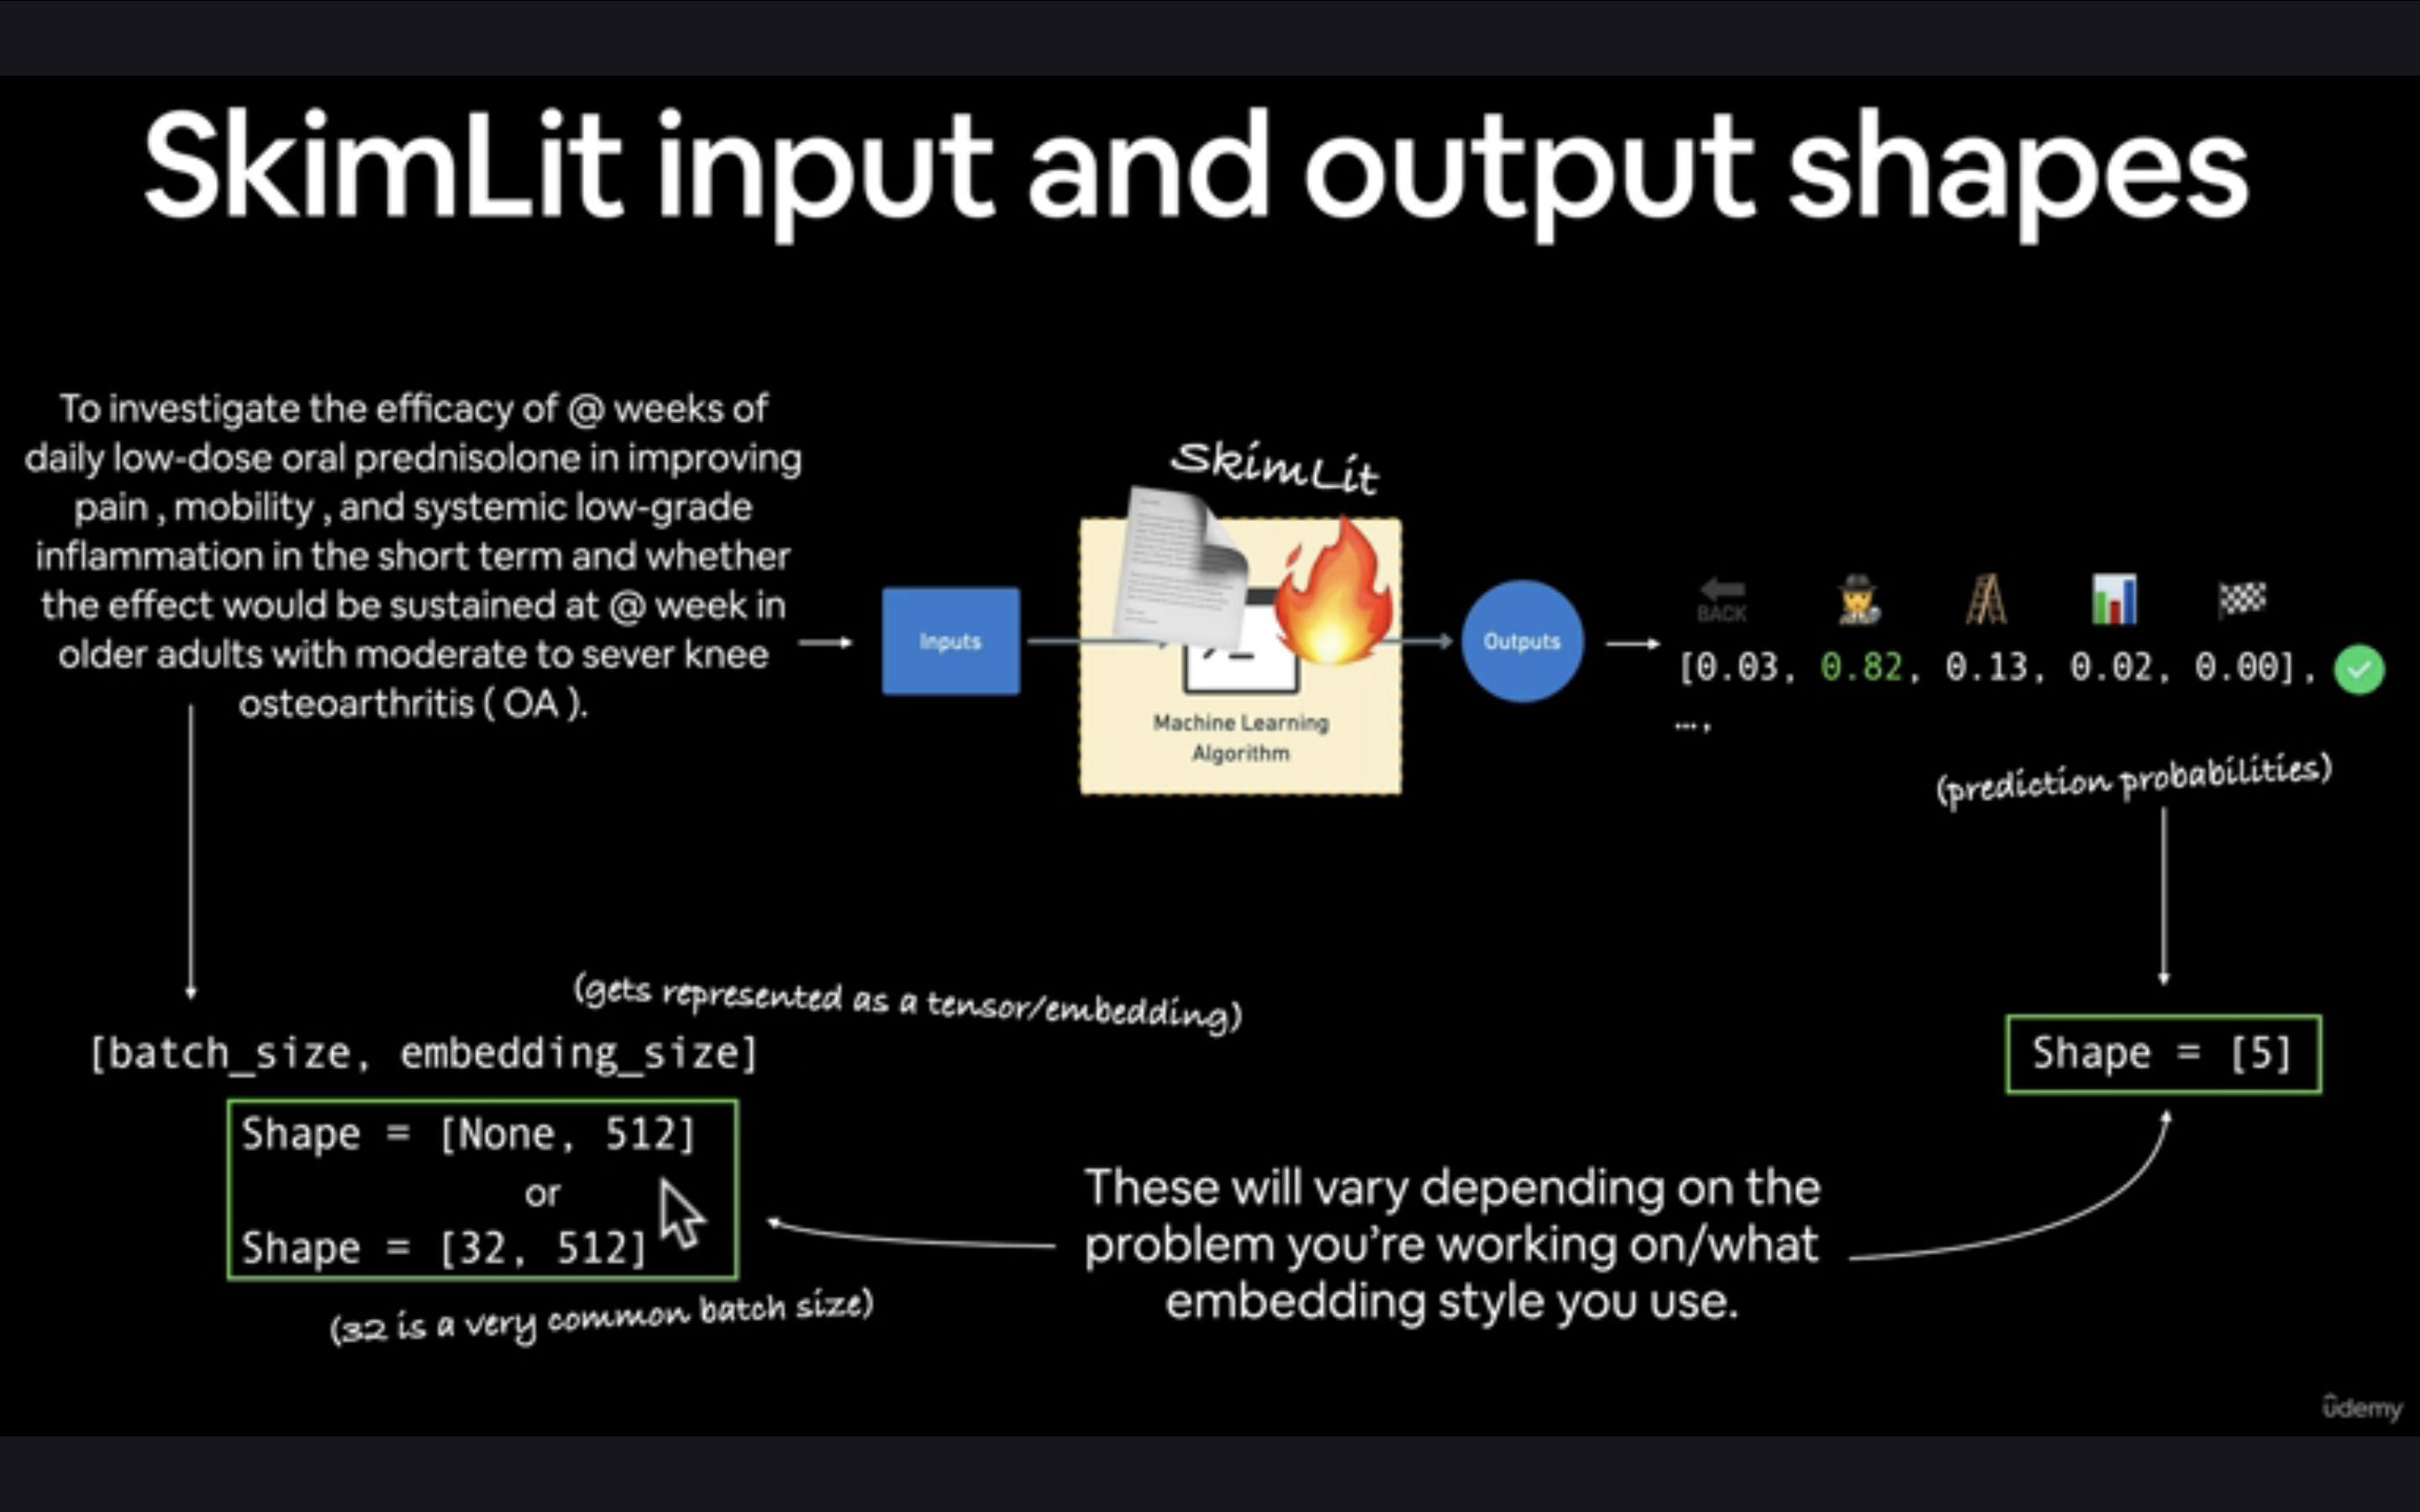

In [71]:
!nvidia-smi

Wed Jan  7 18:49:47 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             30W /   70W |     234MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Get Data

Since we replicating the paper above(Pubmed 200k RCT), lets download the dataset they used

In [72]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [73]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [74]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [75]:
#start our experiment using the 20k dataset with number replaced by "@" sing
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [76]:
#check all the filename in the target dicertory
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

###Preprocess data



In [77]:

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [78]:
data_dir
train_line = get_lines(data_dir+"train.txt")
train_line[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Writing the funcation to turn each of data in format

In [79]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [80]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 409 ms, sys: 61.9 ms, total: 471 ms
Wall time: 472 ms


(180040, 30212, 30135)

In [81]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [82]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df  = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [83]:
print(f"Length of test_sentence: {len(test_sentence)}")
print(f"Length of test_label_encoder: {len(test_label_encoder)}")

Length of test_sentence: 30212
Length of test_label_encoder: 30135


As you can see from the output above, `test_sentence` and `test_label_encoder` have different lengths (30212 vs 30135). They **must** have the same length to create a TensorFlow dataset.

Assuming you have a `test_df` DataFrame, you should extract the sentences and labels from it to ensure they are aligned. Remember to replace `'sentence_column_name'` and `'label_column_name'` with the actual column names in your `test_df`.

In [84]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

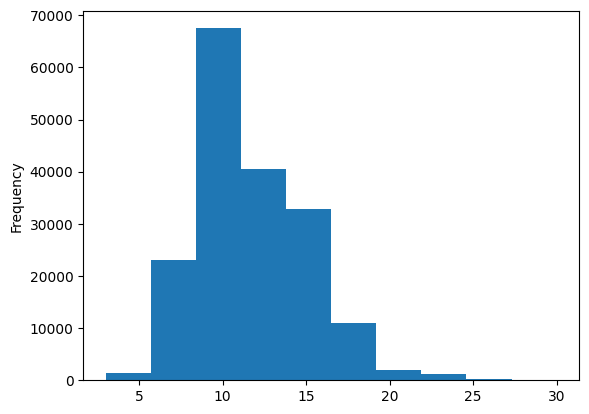

In [85]:
#Let check the lenght of diffrent line
train_df.total_lines.plot.hist()

##Get lists of sentences

In [86]:
#convert abstrac text lines into line
train_sentence = train_df["text"].tolist()
val_sentence = val_df["text"].tolist()
test_sentence = val_df["text"].tolist()
len(train_sentence), len(val_sentence), len(test_sentence)

(180040, 30212, 30212)

In [87]:
test_sentence[:20]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

#Make numeric labels (ML models require numeric labels)

In [88]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_label_encoder = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_label_encoder = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

val_label_encoder = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

train_label_encoder

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Label encode labels

In [89]:

# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [90]:
class_name = label_encoder.classes_

class_name

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

##Starting a series of modeling experiments
As usual we're going to be trying out of bunch of diffrent model and seeing which one works best.
We are goinng start with baseline (TF-IDF Multinative Base Line)

##Model 0: Base line

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import  MultinomialNB
from sklearn.pipeline import Pipeline


#Create a pipline
model_0 = Pipeline(
    [
        ("tf-idf",TfidfVectorizer()),
        ("clf",MultinomialNB())
    ]
)

#Fit the piplint to the training data

model_0.fit(X=train_sentence,
            y=train_labels_encoded
            )


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [92]:
#Evalauate baseline model on validation dataset
model_0.score(
    X=val_sentence,
    y=val_labels_encoded
)

0.7218323844829869

In [93]:
#Make prediction using our baseline
baseline_pred = model_0.predict(
    val_sentence
)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

###Download helper funcation script


In [94]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2026-01-07 18:49:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-01-07 18:49:53 (77.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [95]:
from helper_functions import calculate_results

In [96]:
#calculate results
base_line_results = calculate_results(y_true=val_labels_encoded,
                                      y_pred=baseline_pred
                                      )

In [97]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###Preparing our data for deep sequence models

Create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

In [98]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [99]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentence]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

np.float64(26.338269273494777)

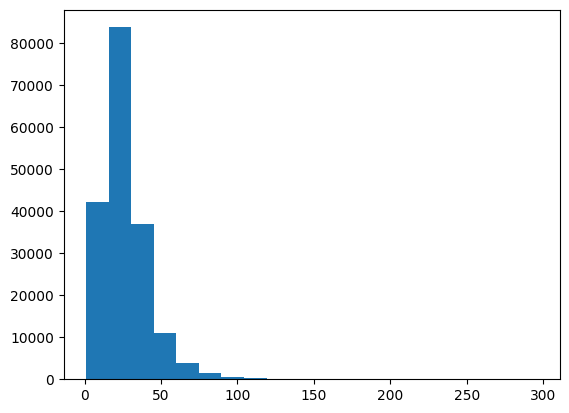

In [100]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);


In [101]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [102]:
# Maximum sentence length in the training set
max(sent_lens)


296

###Create text vectoriser

```
We want to make layer which maps our text from word to number
```



In [103]:

# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000


In [104]:
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences


In [105]:

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentence)

In [106]:
import random
target_sentence = random.choice(train_sentence)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
given the potential for under-reporting , our aim was to compare reporting by patients and physicians of six toxicities ( anorexia , nausea , vomiting , constipation , diarrhea , and hair loss ) within three randomized trials .

Length of text: 39

Vectorized text:
[[  330     2   343    11 12322   246   267    10     6   226  1476    22
     12     3   966     4   356  2942  5096   969  1232  2528  1918     3
   2442   264   219   134    29   233     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [107]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocabulary: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [108]:
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Create Custom Text Embedding


In [109]:
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = "token_embeding"
)

In [110]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
given the potential for under-reporting , our aim was to compare reporting by patients and physicians of six toxicities ( anorexia , nausea , vomiting , constipation , diarrhea , and hair loss ) within three randomized trials .

Sentence after vectorization (before embedding):
[[  330     2   343    11 12322   246   267    10     6   226  1476    22
     12     3   966     4   356  2942  5096   969  1232  2528  1918     3
   2442   264   219   134    29   233     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00469995  0.03360373 -0.02782813 ... -0.01848968  0.01274015
    0.03428752]
  [ 0.04473268 -0.00370917  0.04543854 ... -0.04461223 -0.03191151
    0.04862663]
  [-0.04732586 -0.00348115  0.01683005 ...  0.03380973  0.04159268
   -0.02135451]
  ...
  [ 0.02252069  0.00955868  0.03312926 ...  0.04527568 -0.00410712


##Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

📖 Resource: For best practices on data loading in TensorFlow, check out the following:

* tf.data: [Build TensorFlow input pipelines Better performance with the ](https://www.tensorflow.org/guide/data)
* [tf.data API The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.](https://www.tensorflow.org/guide/data_performance)

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [112]:
#Turn our data into TensorFlow DataSet
train_data = tf.data.Dataset.from_tensor_slices((train_sentence,train_label_encoder))
val_data = tf.data.Dataset.from_tensor_slices((val_sentence,val_label_encoder))
# test_data = tf.data.Dataset.from_tensor_slices((test_sentence,test_label_encoder))


train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [113]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_data.batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 1 (Conv1D with token embeding)
